## Class label visualization
Plot out class counts for all patients, both raw input data as well as after relative class balancing has occurred.

In [1]:
import os
import pyedflib
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch.optim as optim
import numpy as np
from pathlib import Path
from sklearn import metrics
import joblib
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def load_sleep_dataset(path, targets):
    """Extracts all patients' nightly EEG and annotation data
    path : string
        Directory to data/ folder, directory contents should be:
        data/
            interim/
                target_train.json
            raw/
                ...
                sleep-cassette/
                ...
    Returns : Tuple
        [0] List of patient EEG data
        [1] List of patient annotation data
    """
    sleep_cassette_files = os.listdir(f'{path}/raw/sleep-cassette/')

    eeg_list = []
    annotation_list = []

    for target in targets:
        for night in range(1, 3):

            # Find individual patient
            subject_id_str = str(target)
            if len(subject_id_str) == 1:
                subject_id_str = '0' + subject_id_str
            night_str = str(night)

            # Whole night sleep recordings containing EEG
            try:
                eeg = pyedflib.EdfReader(
                    f'{path}/raw/sleep-cassette/SC4' + subject_id_str + night_str + 'E0-PSG.edf')
            except OSError:
                # One patient only has a single night of data, not two nights
                continue
            eeg_signal = eeg.readSignal(0)
            eeg_list.append(np.array(eeg_signal))

            # Annotations of sleep recordings corresponding to EEG
            annotation_file_path = list(filter(
                lambda x: x.startswith(
                    'SC4' + subject_id_str + night_str) and x.endswith('-Hypnogram.edf'),
                sleep_cassette_files))[0]
            annotation = pyedflib.EdfReader(f'{path}/raw/sleep-cassette/' + annotation_file_path)
            annotation_list.append(annotation)

    return (eeg_list, annotation_list)

In [3]:
def get_sleep_stage(index, time_marks, sleep_stages):
    """Determines the sleep stage label for a patient
    at a given point in their nightly data.

    index : Integer
        Current indidvial EEG reading location from 1-D array

    time_marks : Array-like
        Breakpoints denoting when different sleep stages
        occur. Array values are assumed to be starting
        times for each corresponding sleep stage

    sleep_stages : Array-like
        Corresponding sleep stage labels that match the
        breaks denoted by `time_marks`

    Returns : String
        Sleep stage label
    """
    time_index = -1
    for time_mark in time_marks:
        if index >= time_mark:
            time_index += 1
        else:
            break
    return sleep_stages[time_index]

In [4]:
def create_1d_arrays(eeg_list, annotation_list):
    """Build the individual arrays to be later passed into the
    CNN. When walking through nightly EEG data, skip over the
    first two epochs (i.e. 6000 items) so that the first epoch
    that the matrix is built from is able to incorporate it's previous
    two epochs. Likewise, stop walking through EEG data two epochs early.

    eeg_list : list
        Each element of the list is a patient's nightly EEG data

    annotation_list : list
        Each element of the list contains both the patient's
        sleep stage labels as well as the start/stop times for
        each of those labels

    Returns : list
        Each element of list is a list with two elements:
            [0] Numpy matrix of EEG data (length 15k)
            [1] Sleep stage label as string
    """
    data = []
    for subject in range(len(eeg_list)):

        # Collect subject's raw data and labels
        eeg = eeg_list[subject]
        annotation = annotation_list[subject]

        # Gather timing breakpoints for each sleep stage
        sleep_stages = annotation.readAnnotations()[2]
        time_marks = annotation.readAnnotations()[0]
        time_marks *= 100  # Convert to match time mark indices magnitudes from EEG data

        # Iterate through nightly data to build 1D arrays
        start_idx = 6000
        stop_idx = 9000
        two_epochs = 6000
        for index in range(6000, eeg.shape[0] - 6000, 3000):

            # Record target sleep stage label
            label = get_sleep_stage(index, time_marks, sleep_stages)
            if label == 'Sleep stage 4':
                label = 'Sleep stage 3'
            # TODO: consider if keeping W is necessary
            if label in ['Sleep stage ?', 'Movement time', '']:
                continue

            # Shift EEG values to ensure all are positive integers
            eeg_vals = eeg[(start_idx - two_epochs):(stop_idx + two_epochs)]
            eeg_vals_adjust = np.apply_along_axis(
                lambda x: np.round(x + 208).astype(int), axis=0, arr=eeg_vals)

            # Save patient matrix with training label
            data.append([eeg_vals_adjust, label])

            # Reset slicing indices
            start_idx += 3000
            stop_idx += 3000

    return data

In [7]:
all_patient_labels = []
for patient in range(20):
    eeg_list, annotation_list = load_sleep_dataset(data_dir, [patient])
    patient_arrays = create_1d_arrays(eeg_list, annotation_list)
    
    label_count = {}
    for x in patient_arrays:
        label = x[1]
        if label in label_count.keys():
            label_count[label] += 1
        else:
            label_count[label] = 1
    all_patient_labels.append(label_count)

### Raw patient class counts

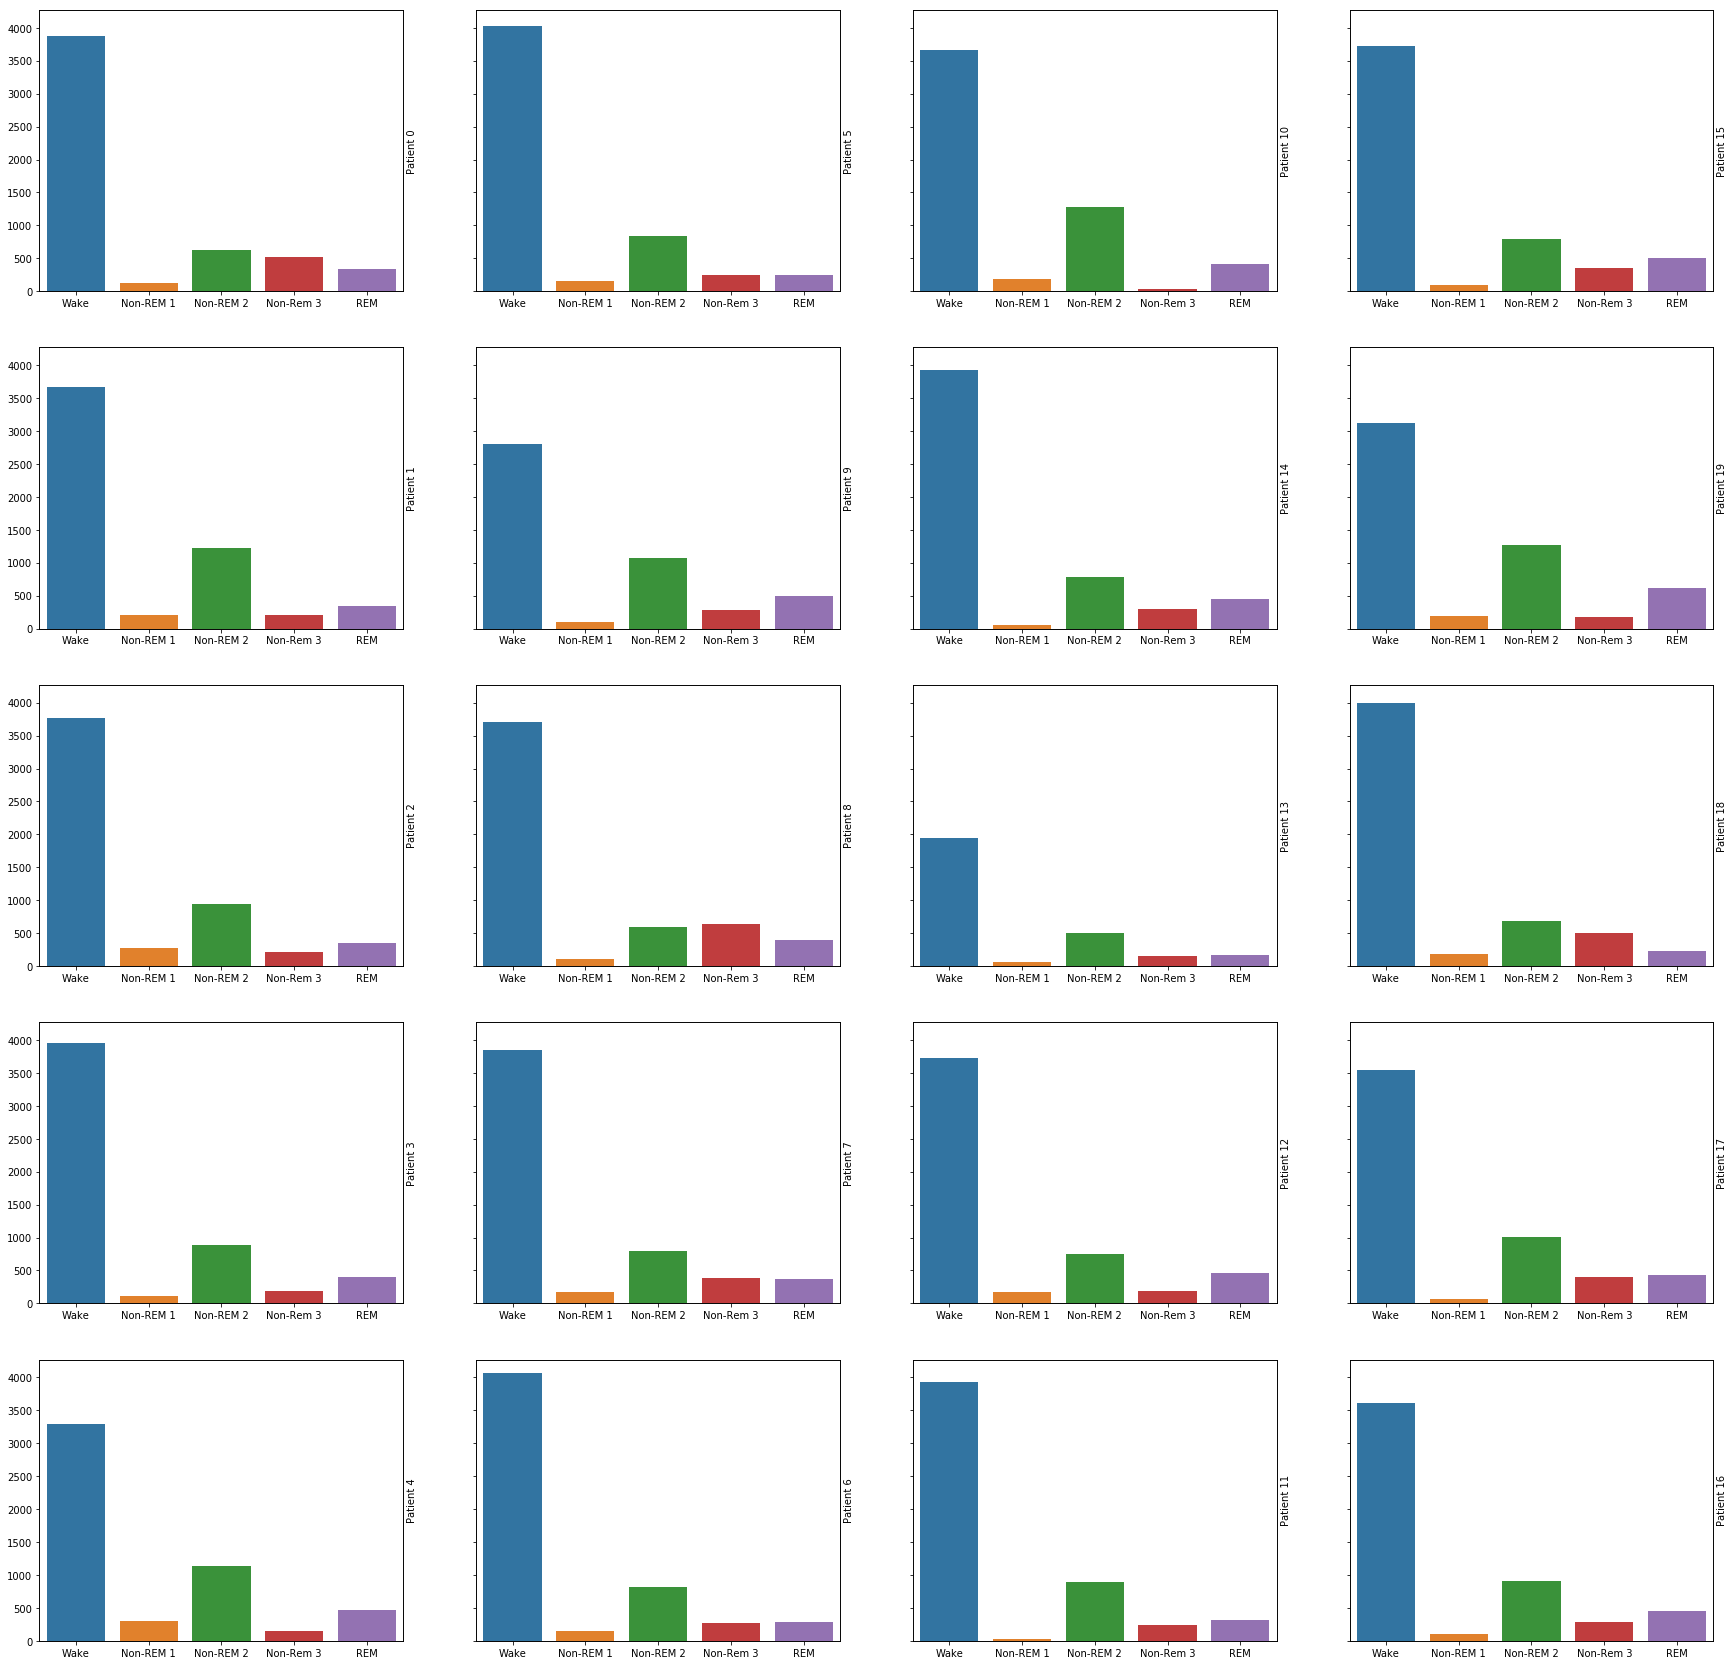

In [8]:
title_map = {
    'Sleep stage W': 'Wake',
    'Sleep stage 1': 'Non-REM 1',
    'Sleep stage 2': 'Non-REM 2',
    'Sleep stage 3': 'Non-Rem 3',
    'Sleep stage R': 'REM'
}

fig, axes = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(30, 30))

for i, patient in enumerate(all_patient_labels):
    if i < 5:
        ax = axes[i, 0]
    elif i < 10:
        ax = axes[5 - i, 1]
    elif i < 15:
        ax = axes[10 - i, 2]
    else:
        ax = axes[15 - i, 3]
        
    df = pd.DataFrame.from_dict(patient, orient='index').reset_index()
    df.rename(columns={'index': 'label', 0: 'count'}, inplace=True)
    df['label'] = df.label.map(title_map)
    
    sns.barplot(x='label', y='count', data=df, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax_right = ax.twinx()
    ax_right.set_ylabel('Patient {}'.format(i))
    ax_right.set_yticklabels([])
    ax_right.set_yticks([])
    
fig.savefig(project_dir / 'graphs' / 'sleep_labels_by_patient.png', bbox_inches='tight')

### Adjusted patient class counts

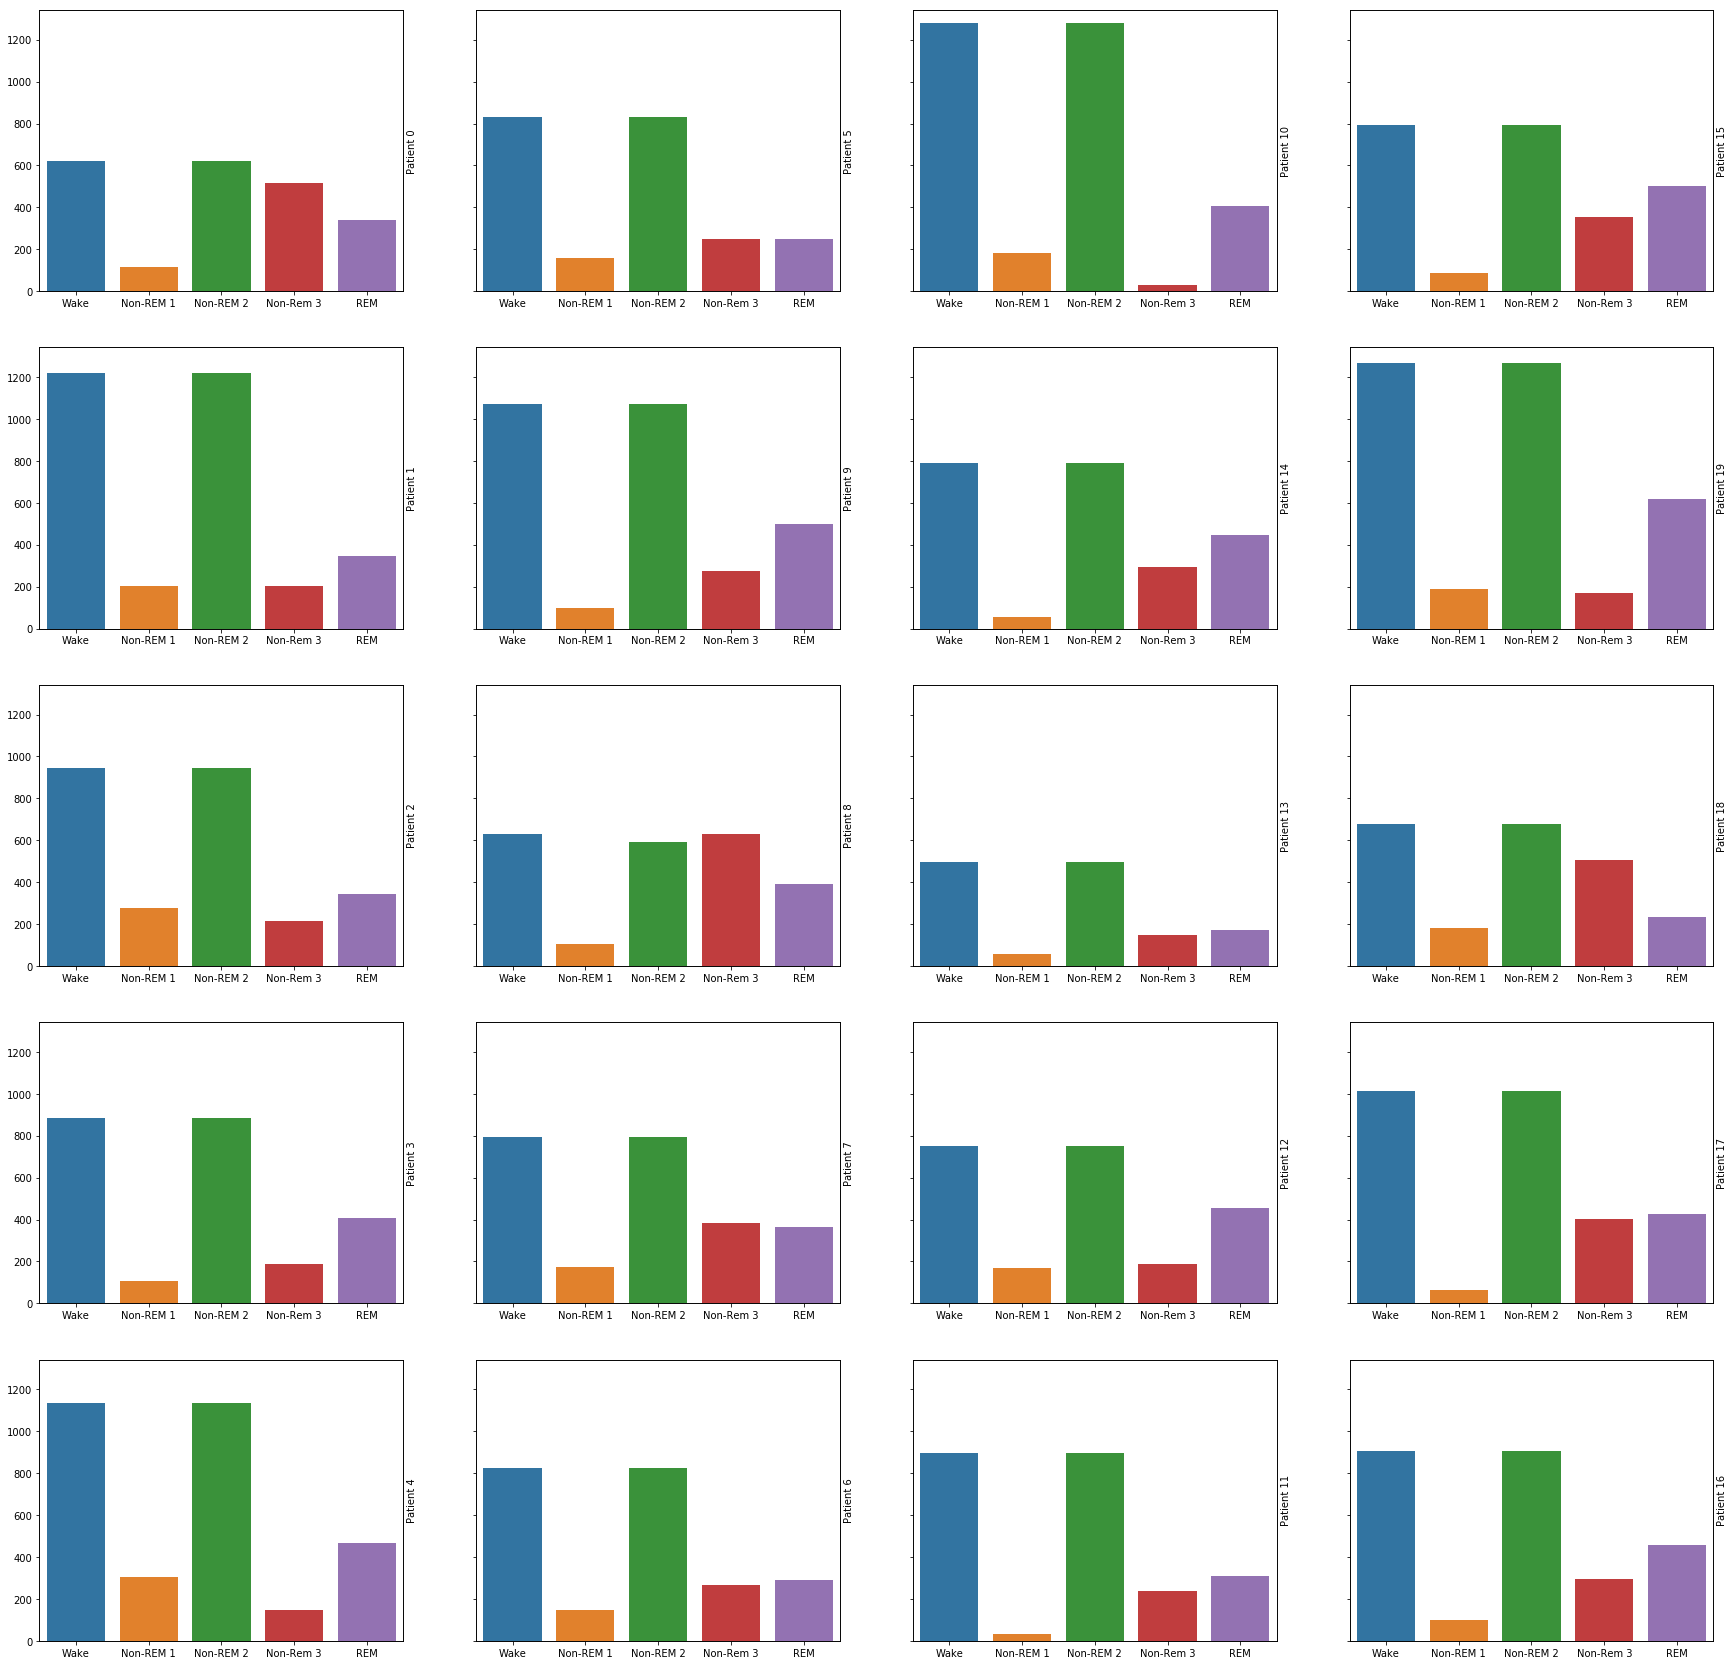

In [9]:
title_map = {
    'Sleep stage W': 'Wake',
    'Sleep stage 1': 'Non-REM 1',
    'Sleep stage 2': 'Non-REM 2',
    'Sleep stage 3': 'Non-Rem 3',
    'Sleep stage R': 'REM'
}

fig, axes = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(30, 30))

for i, patient in enumerate(all_patient_labels):
    if i < 5:
        ax = axes[i, 0]
    elif i < 10:
        ax = axes[5 - i, 1]
    elif i < 15:
        ax = axes[10 - i, 2]
    else:
        ax = axes[15 - i, 3]
        
    df = pd.DataFrame.from_dict(patient, orient='index').reset_index()
    df.rename(columns={'index': 'label', 0: 'count'}, inplace=True)
    df['label'] = df.label.map(title_map)
    
    # Set Wake to count of next largest class
    df.loc[df.label == 'Wake', 'count'] = df.sort_values('count', ascending=False)['count'].values[1]
    
    sns.barplot(x='label', y='count', data=df, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax_right = ax.twinx()
    ax_right.set_ylabel('Patient {}'.format(i))
    ax_right.set_yticklabels([])
    ax_right.set_yticks([])
    
fig.savefig(project_dir / 'graphs' / 'sleep_labels_by_patient_training.png', bbox_inches='tight')